In [2]:
import cv2 #openCV
import exiftool
import os, glob
import numpy as np
import pyzbar.pyzbar as pyzbar
import matplotlib.pyplot as plt
import mapboxgl

print()
print("Successfully imported all required libraries.")
print()

if os.name == 'nt':
    if os.environ.get('exiftoolpath') is None:
        print("Set the `exiftoolpath` environment variable as described above")
    else:
        if not os.path.isfile(os.environ.get('exiftoolpath')):
            print("The provided exiftoolpath isn't a file, check the settings")

try:
    with exiftool.ExifTool(os.environ.get('exiftoolpath')) as exift:
        print('Successfully executed exiftool.')
except Exception as e:
    print("Exiftool isn't working. Double check that you've followed the instructions above.")
    print("The execption text below may help to find the source of the problem:")
    print()
    print(e)


Successfully imported all required libraries.

Successfully executed exiftool.


In [3]:
os.getcwd()

'C:\\Users\\Alexander.Olsen\\Desktop\\images\\Micasense\\imageprocessing-master'

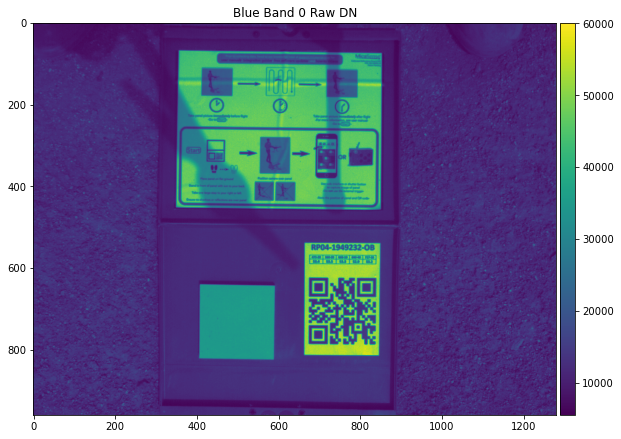

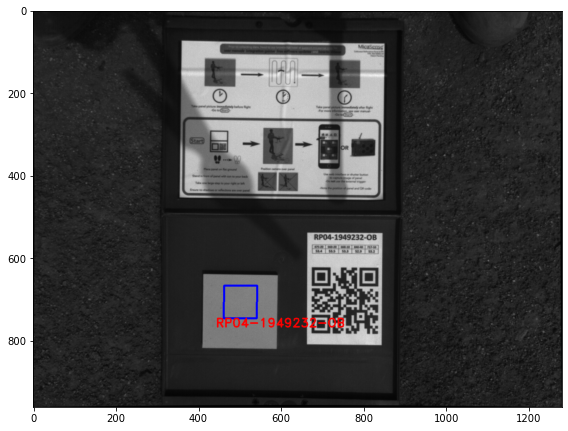

Success! Now you are ready for Part 1 of the tutorial.


In [12]:
from micasense.image import Image
imagePath = os.path.join('.','data','mytestSET','000')
imageName = glob.glob(os.path.join(imagePath,'IMG_0001_1.tif'))[0]

img = Image(imageName)
img.plot_raw(figsize=(8.73,8.73));

from micasense.panel import Panel
panel = Panel(img)
if not panel.panel_detected():
    raise IOError("Panel Not Detected! Check your installation of pyzbar")
else:
    panel.plot(figsize=(8,8));

print('Success! Now you are ready for Part 1 of the tutorial.')

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
import micasense.imageset as imageset
import micasense.capture as capture
import os, glob
import multiprocessing

panelNames = None
useDLS = True

#imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdgeImageSet','0000SET'))
imagePath = os.path.join('.','data','mytestSET')
panelNames = glob.glob(os.path.join(imagePath,'000','IMG_0000_*.tif'))
panelCap = capture.Capture.from_filelist(panelNames)

outputPath = os.path.join(imagePath,'..','stacks')
thumbnailPath = os.path.join(outputPath, '..', 'thumbnails')

overwrite = False # can be set to set to False to continue interrupted processing
generateThumbnails = True

# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

if panelCap is not None:
    if panelCap.panel_albedo() is not None and not any(v is None for v in panelCap.panel_albedo()):
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
else:
    if useDLS:
        img_type='reflectance'
    else:
        img_type = "radiance"

In [23]:
## This progress widget is used for display of the long-running process
f = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Loading")
display(f)
def update_f(val):
    if (val - f.value) > 0.005 or val == 1: #reduces cpu usage from updating the progressbar by 10x
        f.value=val

%time imgset = imageset.ImageSet.from_directory(imagePath, progress_callback=update_f)
update_f(1.0)

FloatProgress(value=0.0, description='Loading', layout=Layout(width='100%'), max=1.0)

Wall time: 1.3 s


# Unwarp and Align

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

## Alignment settings
match_index = 1 # Index of the band 
max_alignment_iterations = 10
warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

print("Alinging images. Depending on settings this can take from a few seconds to many minutes")
# Can potentially increase max_iterations for better results, but longer runtimes
warp_matrices, alignment_pairs = imageutils.align_capture(capture,
                                                          ref_index = match_index,
                                                          max_iterations = max_alignment_iterations,
                                                          warp_mode = warp_mode,
                                                          pyramid_levels = pyramid_levels)

print("Finished Aligning, warp matrices={}".format(warp_matrices))

Alinging images. Depending on settings this can take from a few seconds to many minutes


AttributeError: module 'micasense.capture' has no attribute 'images'